In [1]:
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/ubuntu data/kaggle.json" ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/car-plate-detection

100% 203M/203M [00:01<00:00, 174MB/s]
100% 203M/203M [00:01<00:00, 127MB/s]


In [4]:
!unzip car-plate-detection.zip

Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [5]:
!pip install easyocr
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.9 MB/s eta 0:00:00
--2023-12-25 06:30:35--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  24.7MB/s    in 12s     

2023-12-25 06:30:47 (20.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2023-12-25 06:30:47--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location:

In [6]:
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import easyocr
import os

In [7]:
# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

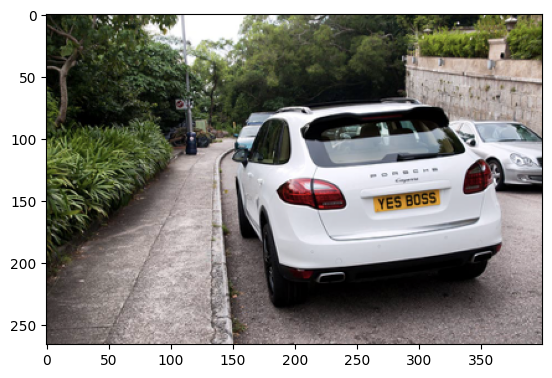

In [17]:
l=os.listdir('./images/')
i=l[0]
img=cv2.imread('./images/'+i)
# img=cv2.imread('./m/5.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_org=img.copy()
gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(img)

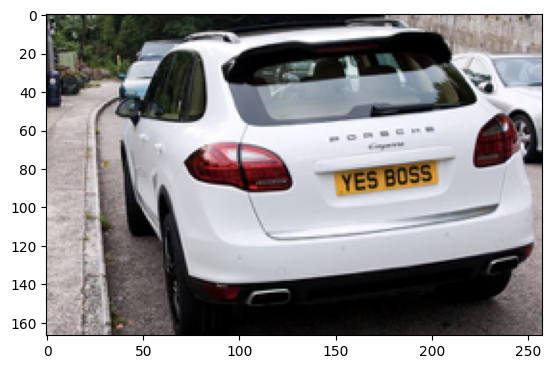

In [18]:
# Detecting objects
blob = cv2.dnn.blobFromImage(img.copy(), 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.50:
            # Object detected
            center_x = int(detection[0] * img.shape[1])
            center_y = int(detection[1] * img.shape[0])
            w = int(detection[2] * img.shape[1])
            h = int(detection[3] * img.shape[0])

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

try:
  # sort the box on area
  sorted_boxes = sorted(zip(boxes, confidences, class_ids), key=lambda x: x[0][2] * x[0][3], reverse=True)
  boxes, confidences, class_ids = zip(*sorted_boxes)
  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

  # Crop and save each detected object

  x, y, w, h = boxes[0]
  roi = img[y:y+h, x:x+w]
  area_new=roi.shape[0]*roi.shape[1]
  area_old=img.shape[0]*img.shape[1]
  ratio=area_new/area_old
  if ratio<0.7:
    gray=cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
    img=roi
    cv2.imwrite("crop.jpg",img)
    plt.imshow(roi)
  else:
    print("taking old image only")
except:
  print("No car detected")

## Yellow number plate

In [23]:
## yellow color detection 0,30,43,54,255,255
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
lower_bound=np.array([0,50,15]) # 0,7,15
upper_bound=np.array([106,255,255]) # 106
mask=cv2.inRange(hsv,lower_bound,upper_bound)
thresh=cv2.bitwise_and(img,img,mask=mask)
thresh=cv2.cvtColor(thresh,cv2.COLOR_RGB2GRAY)

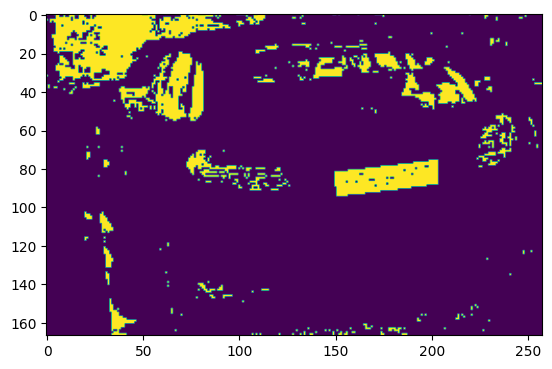

In [24]:
_, thresh = cv2.threshold(thresh,0,255,cv2.THRESH_BINARY)
# thresh=cv2.Canny(thresh,120,500)
plt.imshow(thresh)

## White number plate

In [21]:
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
lower_bound=np.array([0,0,160])  ## 84,30,138
upper_bound=np.array([65,160,255]) ## 173,246,206
mask=cv2.inRange(hsv,lower_bound,upper_bound)
thresh=cv2.bitwise_and(img,img,mask=mask)
thresh=cv2.cvtColor(thresh,cv2.COLOR_RGB2GRAY)

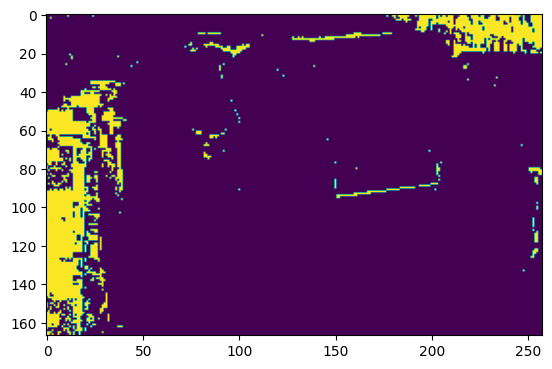

In [22]:
# thresh=cv2.blur(thresh,(3,3))
_, thresh = cv2.threshold(thresh,0,255,cv2.THRESH_BINARY)
# thresh=cv2.Canny(thresh,120,500)
plt.imshow(thresh)

## or alone

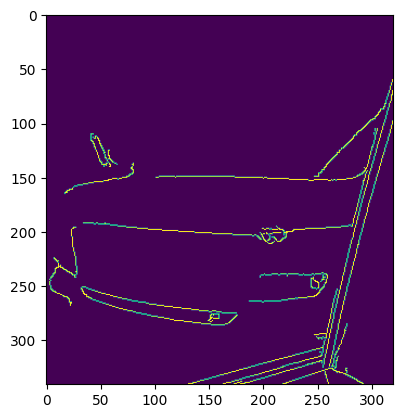

In [ ]:
## or alone

thresh=cv2.Canny(gray,30,300)
plt.imshow(thresh)

##final

In [25]:
cnts, hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts,key=cv2.contourArea, reverse=True)[:30]
location=[]
for c in cnts:
  if any([point[0][0] == 0 or point[0][1] == 0 or point[0][0] == thresh.shape[1] - 1 or point[0][1] == thresh.shape[0] - 1 for point in c]):
    continue
  epsilon = (0.02)*cv2.arcLength(c,True)
  approx=cv2.approxPolyDP(c,epsilon,True)
  if len(approx)==4:
    location.append(approx)
    x1,y1,w1,h1 = cv2.boundingRect(c)
    # new_img=img_org[y1+y:y1+h1+y,x1+x:x+x1+w1]
    new_img=img[y1:y1+h1,x1:x1+w1]
    cv2.imwrite('./cutted/'+i,new_img)
    break

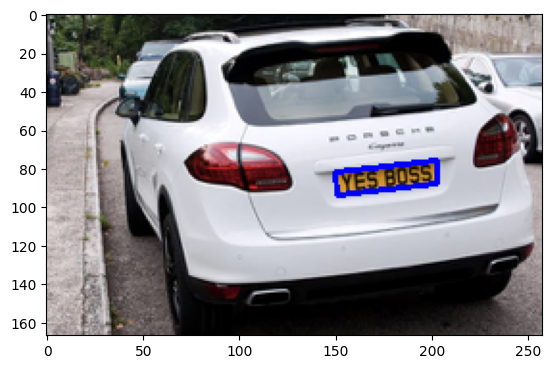

In [26]:
img_c=img.copy()
img_c=cv2.drawContours(img_c,location,-1 ,(0,0,255),2)
plt.imshow(img_c)

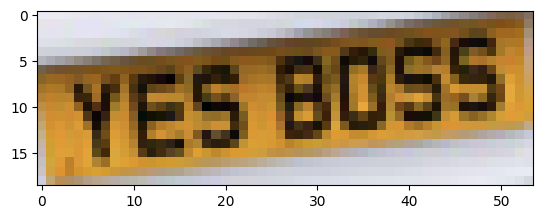

In [27]:
plt.imshow(new_img)

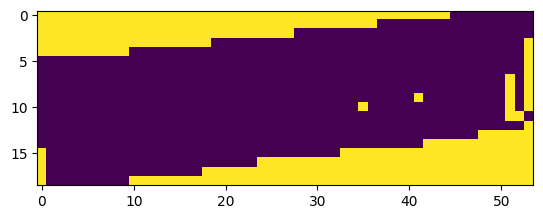

In [32]:
gray_new=cv2.cvtColor(new_img,cv2.COLOR_RGB2GRAY)
# gray_new=cv2.blur(gray_new,(3,3))
# sobelX=cv2.Sobel(gray_new,cv2.CV_64F,1,0,ksize=1)
# sobelY=cv2.Sobel(gray_new,cv2.CV_64F,0,1,ksize=1)
# sobelX=np.uint8(np.absolute(sobelX)) # take mod of -ve values convert to unsighned int
# sobelY=np.uint8(np.absolute(sobelY)) # take mod of -ve values convert to unsighned int
# thresh = cv2.bitwise_or(sobelX,sobelY)
thresh=cv2.adaptiveThreshold(gray_new,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,99,19)
plt.imshow(thresh)

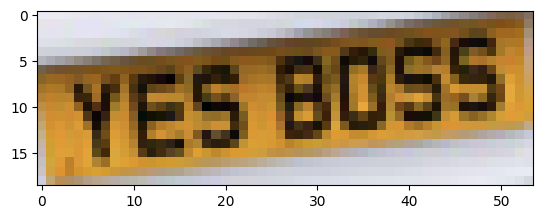

In [33]:
img_c=new_img.copy()
plt.imshow(img_c)

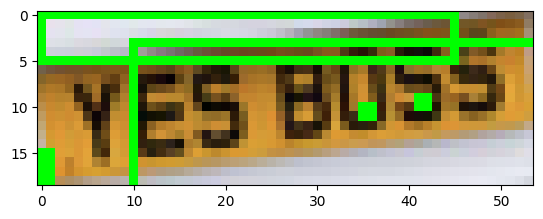

In [34]:
cnts, hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts,key=cv2.contourArea, reverse=True)
for c in cnts:
  area=cv2.contourArea(c)
  epsilon = (0.01)*cv2.arcLength(c,True) ## keep 0.01,0.0001 etc not more than 0.01 it changes dimension of bounding rectangle
  data = cv2.approxPolyDP(c,epsilon,True) ## true return value to data
  hull=cv2.convexHull(data) ## draw a hull
  x,y,w,h = cv2.boundingRect(hull)
  img_c=cv2.rectangle(img_c,(x,y),(x+w,y+h),(0,255,0),1)

plt.imshow(img_c)

In [11]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [35]:
print(reader.readtext(new_img)[0][1])

Yes Boss


Yes Boss


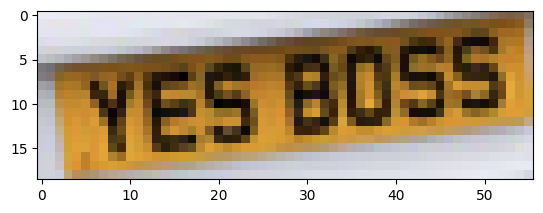

In [36]:
import re

l = './annotations/' + i.split('.')[0] + '.xml'

with open(l, 'rb') as f:
    # Read the file content line by line
    text = b''
    for line in f:
        text += line

    # Convert bytes to string
    text_str = text.decode('utf-8')

    # Use regex to extract values
    xmin_match = re.search(r'<xmin>(\d+)</xmin>', text_str)
    xmax_match = re.search(r'<xmax>(\d+)</xmax>', text_str)
    ymin_match = re.search(r'<ymin>(\d+)</ymin>', text_str)
    ymax_match = re.search(r'<ymax>(\d+)</ymax>', text_str)

    # Extract values
    xmin = int(xmin_match.group(1)) if xmin_match else None
    xmax = int(xmax_match.group(1)) if xmax_match else None
    ymin = int(ymin_match.group(1)) if ymin_match else None
    ymax = int(ymax_match.group(1)) if ymax_match else None
    f.close()
    plt.imshow(img_org[ymin:ymax,xmin:xmax])
print(reader.readtext(img_org[ymin:ymax, xmin:xmax])[0][1])


In [ ]:
### score checking
results=[]

In [13]:
def plt_fig(img):
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

5.jpg


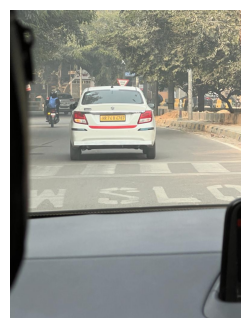

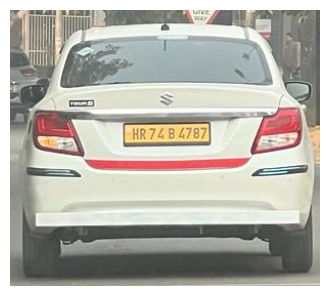

yellow - LHRZLB L787


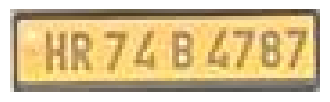

white plate not work


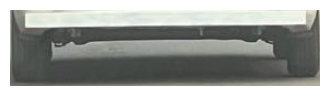

canny- HRZ LB L7871


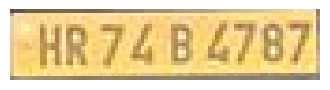



w1.png


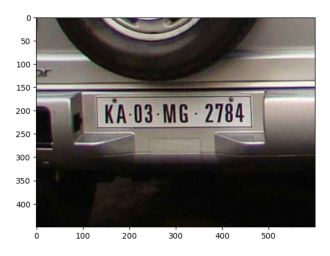

No car detected


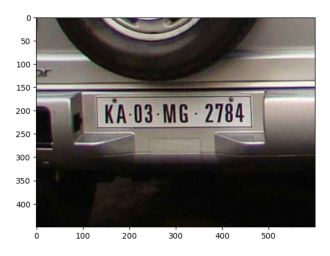

yellow plate not work


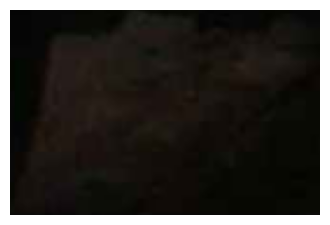

white - Ka 03-MG


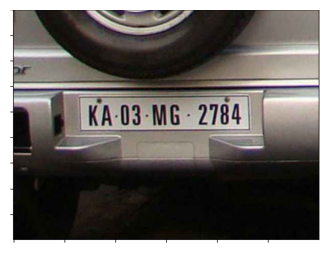

canny- Ka 03-MG


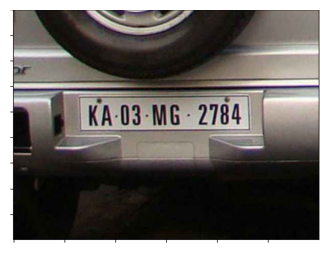



4.jpg


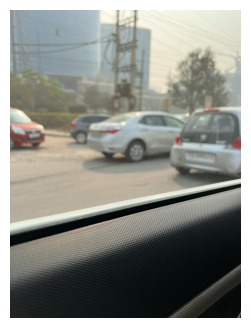

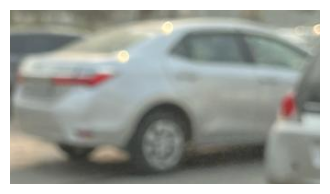

yellow plate not work


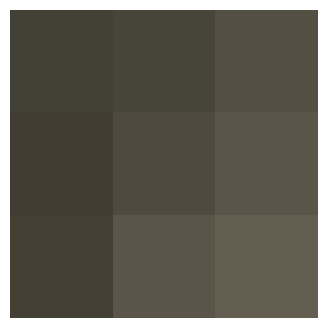

white plate not work


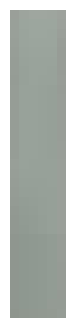

error in  4.jpg


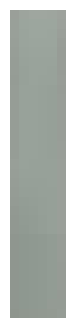



2.jpeg


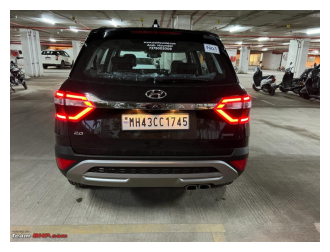

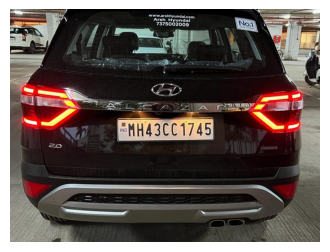

yellow plate not work


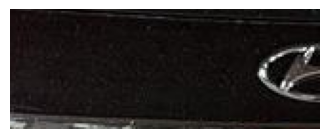

white plate not work


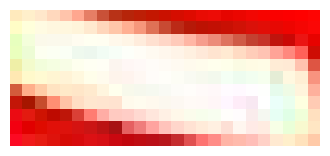

canny- Hh43cc1745


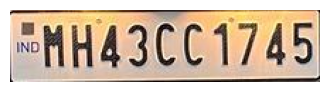



7.jpg


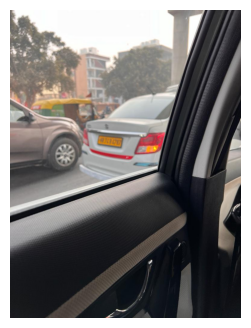

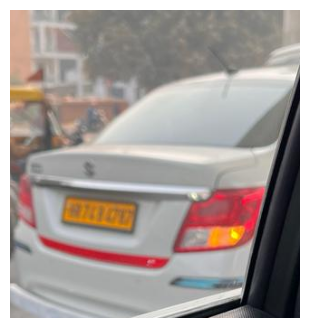

yellow plate not work


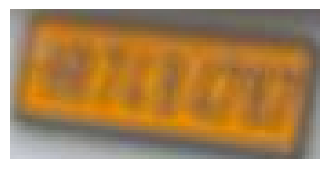

white plate not work


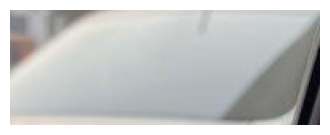

error in  7.jpg


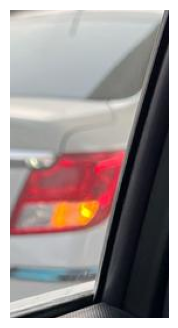



w5.png


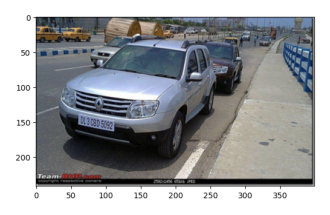

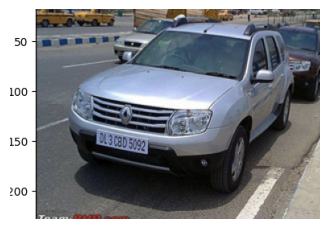

yellow plate not work


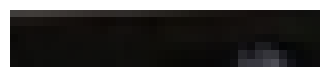

white plate not work


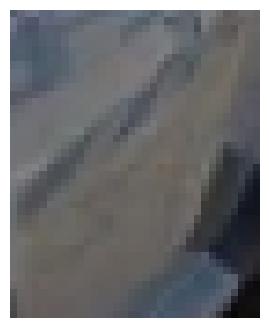

error in  w5.png


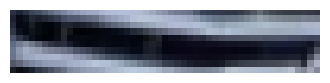



white.png


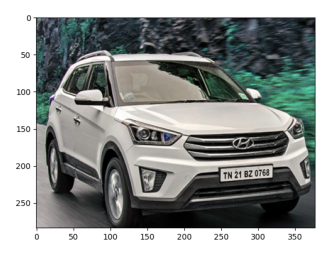

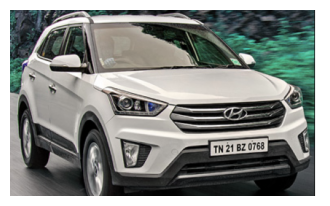

yellow plate not work


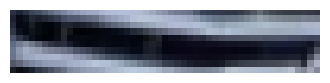

white plate not work


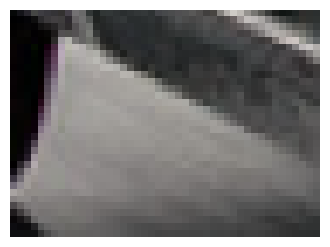

canny- BZ 0768


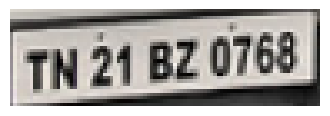



white2.png


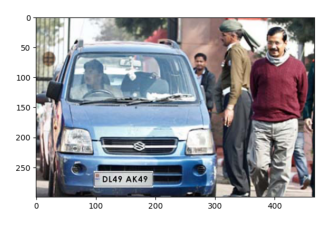

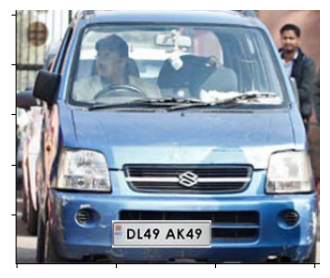

yellow plate not work


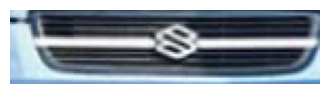

white plate not work


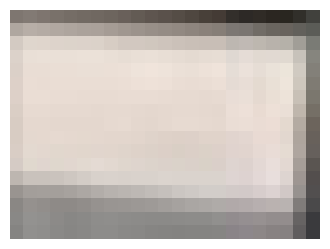

error in  white2.png


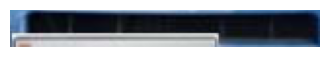



l.png


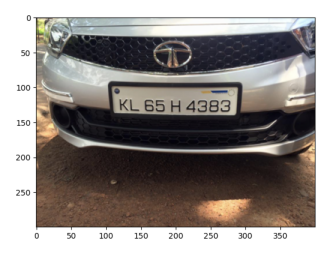

No car detected


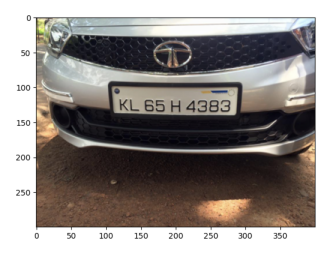

yellow plate not work


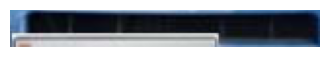

white - KL 85 H4383


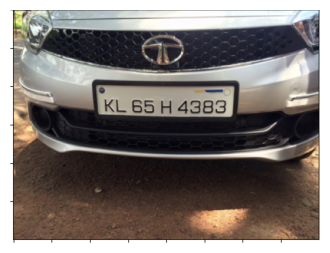

canny- KL 65H4383


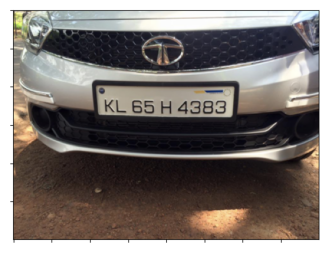



w2.png


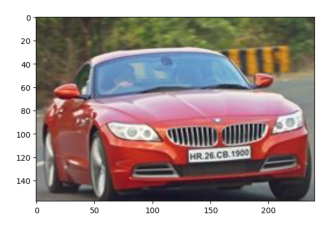

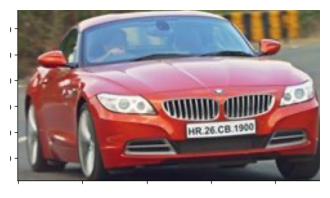

yellow plate not work


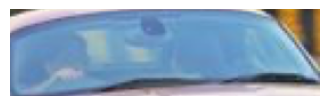

white plate not work


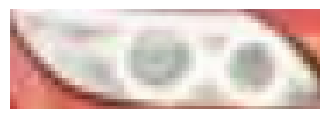

canny- LR 20 C9 1820


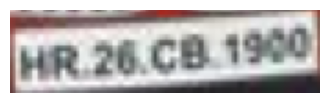

In [16]:
l=os.listdir('./g')
for image in l[0:10]:
  print(image)
  img=cv2.imread('./g/'+image)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt_fig(img)
  img_org=img.copy()
  gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Detecting objects
  blob = cv2.dnn.blobFromImage(img.copy(), 0.00392, (416, 416), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(output_layers)

  # Showing informations on the screen
  class_ids = []
  confidences = []
  boxes = []
  for out in outs:
      for detection in out:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.50:
              # Object detected
              center_x = int(detection[0] * img.shape[1])
              center_y = int(detection[1] * img.shape[0])
              w = int(detection[2] * img.shape[1])
              h = int(detection[3] * img.shape[0])

              # Rectangle coordinates
              x = int(center_x - w / 2)
              y = int(center_y - h / 2)

              boxes.append([x, y, w, h])
              confidences.append(float(confidence))
              class_ids.append(class_id)

  try:
    # sort the box on area
    sorted_boxes = sorted(zip(boxes, confidences, class_ids), key=lambda x: x[0][2] * x[0][3], reverse=True)
    boxes, confidences, class_ids = zip(*sorted_boxes)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Crop and save each detected object

    x, y, w, h = boxes[0]
    roi = img[y:y+h, x:x+w]
    area_new=roi.shape[0]*roi.shape[1]
    area_old=img.shape[0]*img.shape[1]
    ratio=area_new/area_old
    if ratio<0.7:
      gray=cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
      img=roi
      cv2.imwrite("crop.jpg",img)
    else:
      print("taking old image only")
  except:
    print("No car detected")
  plt_fig(img)
  try:
    ##yellow
    ## yellow color detection 0,30,43,54,255,255
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_bound=np.array([0,50,15])
    upper_bound=np.array([106,255,255])
    mask=cv2.inRange(hsv,lower_bound,upper_bound)
    res=cv2.bitwise_and(img,img,mask=mask)
    res=cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
    thresh=cv2.blur(res,(3,3))
    _, thresh = cv2.threshold(res,0,255,cv2.THRESH_BINARY)

  #####
    cnts, hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts,key=cv2.contourArea, reverse=True)[:30]
    location=[]
    for c in cnts:
      if any([point[0][0] == 0 or point[0][1] == 0 or point[0][0] == thresh.shape[1] - 1 or point[0][1] == thresh.shape[0] - 1 for point in c]):
          continue
      epsilon = (0.03)*cv2.arcLength(c,True)
      approx=cv2.approxPolyDP(c,epsilon,True)
      if len(approx)==4:
        location.append(approx)
        x1,y1,w1,h1 = cv2.boundingRect(c)
        # new_img=img_org[y1+y:y1+h1+y,x1+x:x+x1+w1]
        new_img=img[y1:y1+h1,x1:x1+w1]
        cv2.imwrite('./cutted/'+image,new_img)
        break
    text=reader.readtext(new_img)[0][1]
    print("yellow -",text)
    # pass
  #####
  except:
    print("yellow plate not work")
  plt_fig(new_img)
  try:
  ##white plate
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    lower_bound=np.array([0,0,100])
    upper_bound=np.array([65,63,255])
    mask=cv2.inRange(hsv,lower_bound,upper_bound)
    res=cv2.bitwise_and(img,img,mask=mask)
    thresh=cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
  #####
    _, thresh = cv2.threshold(thresh,0,255,cv2.THRESH_BINARY)
    cnts, hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts,key=cv2.contourArea, reverse=True)[:30]
    location=[]
    for c in cnts:
      if any([point[0][0] == 0 or point[0][1] == 0 or point[0][0] == thresh.shape[1] - 1 or point[0][1] == thresh.shape[0] - 1 for point in c]):
        continue
      epsilon = (0.03)*cv2.arcLength(c,True)
      approx=cv2.approxPolyDP(c,epsilon,True)
      if len(approx)==4:
        location.append(approx)
        x1,y1,w1,h1 = cv2.boundingRect(c)
        # new_img=img_org[y1+y:y1+h1+y,x1+x:x+x1+w1]
        new_img=img[y1:y1+h1,x1:x1+w1]
        cv2.imwrite('./cutted/'+image,new_img)
        break
    text=reader.readtext(new_img)[0][1]
    print("white -",text)
    # pass
  #####
  except:
    print("white plate not work")
  plt_fig(new_img)
  try:
    thresh=cv2.blur(gray,(3,3))
    thresh=cv2.Canny(thresh,30,300)
  #####
    cnts, hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts,key=cv2.contourArea, reverse=True)[:30]
    location=[]
    for c in cnts:
      if any([point[0][0] == 0 or point[0][1] == 0 or point[0][0] == thresh.shape[1] - 1 or point[0][1] == thresh.shape[0] - 1 for point in c]):
        continue
      epsilon = (0.03)*cv2.arcLength(c,True)
      approx=cv2.approxPolyDP(c,epsilon,True)
      if len(approx)==4:
        location.append(approx)
        x1,y1,w1,h1 = cv2.boundingRect(c)
        # new_img=img_org[y1+y:y1+h1+y,x1+x:x+x1+w1]
        new_img=img[y1:y1+h1,x1:x1+w1]
        cv2.imwrite('./cutted/'+image,new_img)
        break
    text=reader.readtext(new_img)[0][1]
    print("canny-",text)
    # pass
  #####
  except:
    print("error in ",image)
  plt_fig(new_img)
  print("\n")